# Tomato diseases image classification 

## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


# Get the data location

In [ ]:
!nvidia-smi

## Import necessary libraries

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import numpy as np
import pandas as pd
from glob import glob

In [ ]:
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/My Drive/datasets/Plants/tomato/train'
validation_path = '/content/drive/My Drive/datasets/Plants/tomato/valid'

# Observe the data in the dataset

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  


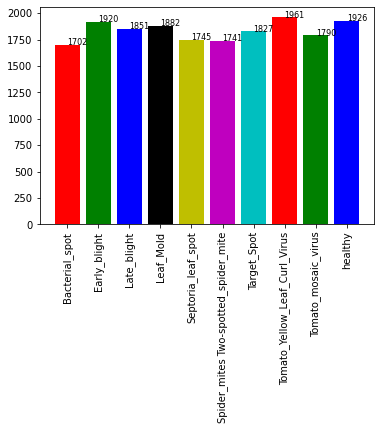

In [ ]:
def observe_data(fpath):
  import pandas as pd
  import matplotlib.pyplot as plt

  data = {}

  plant_classes = [x[0] for x in os.walk(fpath) ]
  for fpath in plant_classes[1:]:
    items = os.listdir(fpath)
    data[fpath.split('___')[-1]] = len(items)
    
  df = pd.DataFrame(list(data.items() ), columns=['class', 'number of images'])

  plt.bar(df['class'], df['number of images'], color='rgbkymc')
  for index, value in enumerate(df['number of images']):
      s = '{}'.format(value)
      plt.text(index,value , str(s), fontsize=8)
  plt.xticks(rotation=90)
  plt.show()
  return df

df = observe_data(train_path)


In [ ]:
from glob import glob
folders = glob('/content/drive/My Drive/datasets/tomatoes/train/*')
folders

['/content/drive/My Drive/datasets/tomatoes/train/Tomato___Bacterial_spot',
 '/content/drive/My Drive/datasets/tomatoes/train/Tomato___Early_blight',
 '/content/drive/My Drive/datasets/tomatoes/train/Tomato___Late_blight',
 '/content/drive/My Drive/datasets/tomatoes/train/Tomato___Leaf_Mold',
 '/content/drive/My Drive/datasets/tomatoes/train/Tomato___Septoria_leaf_spot',
 '/content/drive/My Drive/datasets/tomatoes/train/Tomato___Spider_mites Two-spotted_spider_mite',
 '/content/drive/My Drive/datasets/tomatoes/train/Tomato___Target_Spot',
 '/content/drive/My Drive/datasets/tomatoes/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 '/content/drive/My Drive/datasets/tomatoes/train/Tomato___Tomato_mosaic_virus',
 '/content/drive/My Drive/datasets/tomatoes/train/Tomato___healthy']

## Transfer Inception V3
I will be using transfer learning and inception V3 will be used

In [ ]:
inception = InceptionV3(input_shape= IMAGE_SIZE + [3],
                        weights='imagenet',
                        include_top=False)

87916544/87910968 [==============================] - 3s 0us/step


I ...

In [ ]:
for layer in inception.layers:
  layer.trainable=False

## Flatten the model and create the ouput layer

In [ ]:
x = Flatten()(inception.output)
prediction = Dense(len(folders), activation='softmax')(x)

# create a mode object
model = Model(inputs=inception.input, outputs=prediction)

# view the structure of the model
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

## set mode optimizer

In [ ]:
model.compile( loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


## input processing and image argumentation 


In [ ]:
train_datagen = ImageDataGenerator(
                rescale=1./255,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True)

# Validation set should not be argumented
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
%time
start = time()


train_generator = train_datagen.flow_from_directory(
                train_path,                  # target directory
                target_size=IMAGE_SIZE,     # resize image to 224 x 224
                batch_size=20,
                class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
                validation_path,
                target_size=IMAGE_SIZE,
                batch_size=20,
                class_mode='categorical')


history = model.fit_generator(
            train_generator,
            validation_data=validation_generator,
            epochs=20,
            steps_per_epoch=len(train_generator),
            validation_steps=len(validation_generator))

base_dir = '/content/drive/My Drive/datasets/tomatoes'
model.save(base_dir + '/tomato_inception_v3.h5')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.53 µs
Found 18345 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
918/918 [==============================] - 12611s 14s/step - loss: 3.4982 - accuracy: 0.6866 - val_loss: 3.0378 - val_accuracy: 0.7322
Epoch 2/20
918/918 [==============================] - 256s 279ms/step - loss: 2.9989 - accuracy: 0.7830 - val_loss: 4.1783 - val_accuracy: 0.7588
Epoch 3/20
918/918 [==============================] - 257s 280ms/step - loss: 2.9122 - accuracy: 0.8178 - val_loss: 3.4999 - val_accuracy: 0.7906
Epoch 4/20
918/918 [==============================] - 260s 283ms/step - loss: 2.7202 - accuracy: 0.8398 - val_loss: 3.4727 - val_accuracy: 0.8087
Epoch 5/20
918/918 [==============================] - 258s 281ms/step - loss: 2.5525 - accuracy: 0.8536 - val_loss: 3.2544 - val_accuracy: 0.8260
Epoch 6/20
918/918 [=======================

## Plot

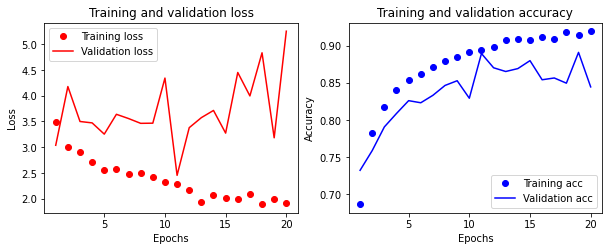

In [ ]:
def plot_history(history):
    import pandas as pd
    import matplotlib.pyplot as plt
    history_dict = history.history
    df = pd.DataFrame(history_dict)

    plt.rcParams['figure.figsize'] = [10, 3.5]
    fig, axs = plt.subplots(1, 2)
    plt.subplots_adjust(hspace=0.5, wspace=0.2)
    p1, p2 = axs[0], axs[1]

    epochs = range(1, len(df.index) + 1)
    p1.plot(epochs, df[df.columns[0]], 'ro', label='Training loss')
    p1.plot(epochs, df[df.columns[2]], 'r', label='Validation loss')
    p1.set_title('Training and validation loss')
    p1.set_xlabel('Epochs')
    p1.set_ylabel('Loss')
    p1.legend()

    p2.plot(epochs, df[df.columns[1]], 'bo', label='Training acc')
    p2.plot(epochs, df[df.columns[3]], 'b', label='Validation acc')
    p2.set_title('Training and validation accuracy')
    p2.set_xlabel('Epochs')
    p2.set_ylabel('Accuracy')
    p2.legend()

    plt.show()

plot_history(history)

In [ ]:
from tensorflow.keras.models import Sequential, save_model, load_model
import numpy as np

IMAGE_SIZE = [224, 224]
filepath = '/content/drive/My Drive/datasets/Plants/tomato/tomato_inception_v3.h5'

model = load_model(
    filepath,
    custom_objects=None,
    compile=True)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(
                validation_path,
                target_size=IMAGE_SIZE,
                batch_size=20,
                class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(validation_generator, steps=50)
print('test acc:', test_acc)


Found 4585 images belonging to 10 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
test acc: 0.8529999852180481


# Observing Model Result


In [ ]:
from glob import glob
folders = glob('/content/drive/My Drive/datasets/tomatoes/train/*')
labels = [ x.split('___')[-1] for x in folders]
labels

['Bacterial_spot',
 'Early_blight',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Spider_mites Two-spotted_spider_mite',
 'Target_Spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato_mosaic_virus',
 'healthy']

In [ ]:
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = [224, 224]
batch_size = 15
test_path = '/content/drive/My Drive/datasets/tomatoes/valid/Tomato___Target_Spot'

test_filenames = os.listdir(test_path)
test_df = pd.DataFrame({'filename': test_filenames})

nb_samples = test_df.shape[0]

test_gen = ImageDataGenerator(rescale=1./255)

test_set = test_gen.flow_from_dataframe(
    test_df, 
    test_path, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False)

Found 457 validated image filenames.


## Predict

In [ ]:
predict = model.predict_generator(test_set, steps=np.ceil(nb_samples/batch_size))

In [ ]:
test_df['raw_category'] = 0
test_df['category'] = np.argmax(predict, axis=-1)

for i in range(len(test_df)):
  x = test_df['category'].iloc[i]
  test_df['raw_category'].iloc[i] = predict[i][x]
# test_df['raw_category'] = test_df['category'].apply(lambda x: predict[x])
test_df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


filename  category  raw_category
0  003a5321-0430-42dd-a38d-30ac4563f4ba___Com.G_T...         5           1.0
1  003a5321-0430-42dd-a38d-30ac4563f4ba___Com.G_T...         6           1.0
2  0197df47-a9cb-4b6c-b72c-ac0e9af6d135___Com.G_T...         6           1.0
3  01e0b8b1-e713-4c6d-973b-f7636280c58a___Com.G_T...         5           1.0
4  01f0e0cb-83a7-4190-9645-bd06b70c8d65___Com.G_T...         9           1.0

In [ ]:
test_df.category.value_counts()


6    313
5     92
9     26
8     16
4      4
0      3
1      2
3      1
Name: category, dtype: int64

In [ ]:
test_df.raw_category.min()

0.5131288766860962

In [ ]:
fil = test_df['category'] != 6
test_df[ fil ].head(20)

filename  category  raw_category
0   003a5321-0430-42dd-a38d-30ac4563f4ba___Com.G_T...         5      1.000000
3   01e0b8b1-e713-4c6d-973b-f7636280c58a___Com.G_T...         5      1.000000
4   01f0e0cb-83a7-4190-9645-bd06b70c8d65___Com.G_T...         9      1.000000
10  04a27dd5-fdd0-40b7-aa5a-527e15f84a99___Com.G_T...         5      1.000000
11  04a27dd5-fdd0-40b7-aa5a-527e15f84a99___Com.G_T...         5      1.000000
12  05991e8b-e178-450f-8da9-d7c10bd2cda9___Com.G_T...         5      1.000000
16  05fa9fcd-ce4c-4c47-aabf-6d794ada4e1c___Com.G_T...         5      1.000000
17  06a52af1-8456-4d7f-98bc-d5ec26be7083___Com.G_T...         5      1.000000
19  06ddddf1-c107-4e34-9546-676f00f52254___Com.G_T...         9      1.000000
20  0a3b6099-c254-4bc3-8360-53a9f558a0c4___Com.G_T...         5      1.000000
21  0a458dfc-b513-44f2-a3ce-dab4c3adb939___Com.G_T...         5      1.000000
22  0a51617c-ecb5-42ce-9d34-300307be3465___Com.G_T...         5      1.000000
23  0a51617c-ecb5-42ce-9d34-300307be3465___Com.G_T...         9      1.000000
25  0ac9e61f-8dda-4628-bbf9-4fd81012b7a3___Com.G_T...         8      0.999999
26  0adf2e61-79af-4129-aae0-f41f73b1725f___Com.G_T...         9      1.000000
29  0b6c4305-0cdc-4150-914b-5d7a5acb7881___Com.G_T...         9      1.000000
30  0c2bd887-092f-410d-ac56-9b96110665c8___Com.G_T...         9      1.000000
40  0df45326-8aa9-49bf-a2fd-e7f454c2dfbf___Com.G_T...         5      0.999931
41  0df45326-8aa9-49bf-a2fd-e7f454c2dfbf___Com.G_T...         8      1.000000
42  0e8a96d7-528a-4d09-8263-2a2d92f3c3b1___Com.G_T...         5      0.803480

In [ ]:
labels = [ x.split('___')[-1] for x in folders]
labels

['Bacterial_spot',
 'Early_blight',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Spider_mites Two-spotted_spider_mite',
 'Target_Spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato_mosaic_virus',
 'healthy']

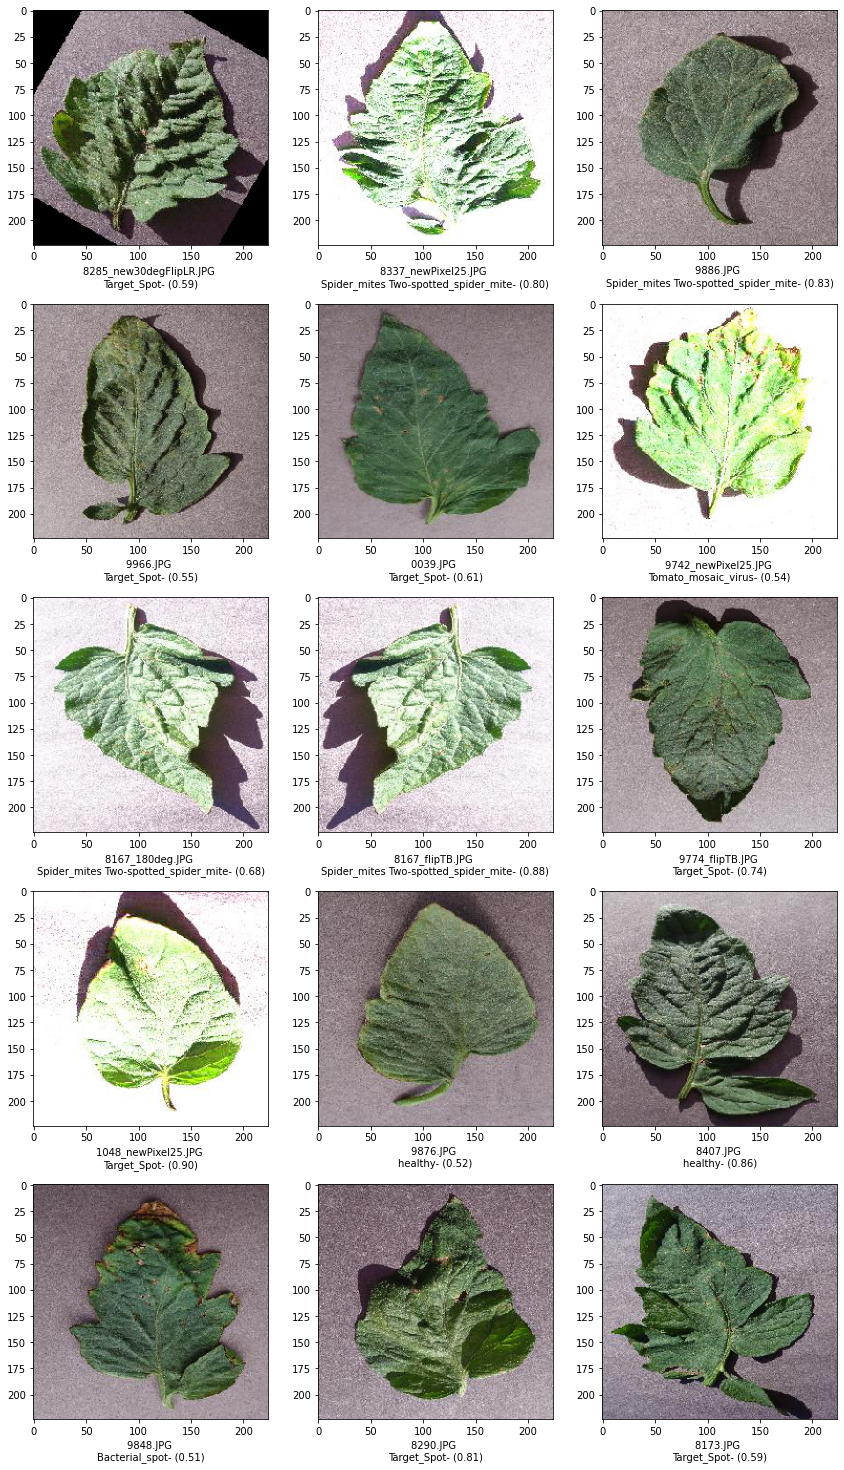

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.image import load_img

fil = (test_df['raw_category'] > 0.5) & (test_df['raw_category'] < 0.9)

sample_test = test_df[fil].head(18)
sample_test.head()
plt.figure(figsize=(12, 24))

i = 0
for index, row in sample_test.iterrows():
    i += 1

    filename = row['filename']
    category = row['raw_category']
    c = row['category']


    # print(index)
    img = load_img(test_path + '/' + filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, i)
    plt.imshow(img)
    plt.xlabel(f'{filename.split(" ")[-1]} \n{labels[c]}' + '- (' + "{:.2f}".format(category) + ')' )
plt.tight_layout()
plt.show()